# Preprocessing Notes

I believe there are 2 crucial components to this experiment that are **more important** than type of Neural Network:
- collection of good data with various scenarios
- preporcesing of the images to remove unnecessary training burden

## Steps 

- Crop the images
- Apply mask to leave only essential data
- Grayscale (see "Conclusions and assumptions")
- Blur the image to remove pixelation and smooth the embankments
- POSSIBLY: Detect "Canny Edges"
- POSSIBLY: Use Hugh algorithm to connect dots (draw lines)
- POSSIBLY: throw out **everything** else except left/right lanes
- Scale down the images to 28x28 if possible
- Visually verify all kinds of landscapes 
    - if I (human) can tell immediately how to steer then I can teach Neural Network to do so, too.

In [1]:
data_dir = "../../../DATA/behavioral_cloning_data/"
import csv

# TODO implement batch_from, batch_to - I did not need it for 8037 rows
# TODO implement has_header_row
def read_csv(file_path):
    # Opening spreadsheet to read in TEXT mode: 'rt'
    with open(file_path, 'rt') as csvfile:
        # Most common format of CSV, TODO improve
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='"') 
        row_counter = 0
        headers = []
        data = []
        for row in spamreader:
            row_counter = row_counter + 1
            
            if row_counter == 1:
                headers = row
                # print (type(row))
                # print ( row)
                # print ('\t '.join(row))
            elif 1 < row_counter < 3:
                # print (type(row))
                # print ( row)
                # print ('\t '.join(row))
                data.append(row)
            else:
                data.append(row)
        print("row_counter", row_counter)
        return headers, data
    
# TEST:    
headers, data = read_csv(file_path = data_dir + 'driving_log.csv')
print("headers \n",headers)
print("3rd row of data \n",data[2:3])

row_counter 8037
headers 
 ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
3rd row of data 
 [['IMG/center_2016_12_01_13_31_12_937.jpg', ' IMG/left_2016_12_01_13_31_12_937.jpg', ' IMG/right_2016_12_01_13_31_12_937.jpg', ' 0', ' 0', ' 0', ' 1.453011']]


In [2]:
def get_image_center_values(matrix):
    column_image_center = 0
    return [row[column_image_center] for row in matrix]

def get_image_left_values(matrix):
    column_image_left = 1
    return [row[column_image_left] for row in matrix]

def get_image_right_values(matrix):
    column_image_right = 2
    return [row[column_image_right] for row in matrix]

def get_steering_values(matrix):
    column_steering = 3
    return [float(row[column_steering]) for row in matrix]

def get_throttle_values(matrix):
    column_throttle = 4
    return [float(row[column_throttle]) for row in matrix]

def get_brake_values(matrix):
    column_brake = 5
    return [float(row[column_brake]) for row in matrix]

def get_speed_values(matrix):
    column_speed = 6
    return [float(row[column_speed]) for row in matrix]

#TEST:
speed_values = get_speed_values(data)
print("print ~53rd speed value", speed_values[51:53]) 

steering_values = get_steering_values(data)
print("print ~53rd steering value", steering_values[51:53]) 

print ~53rd speed value [2.124567, 3.286475]
print ~53rd steering value [0.0617599, 0.05219137]


In [3]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt

def margin(value):
    return value*(5/100)

def plot_histogram(name, values, change_step):
    
    min_value = min(values)
    print("min_value", min_value)
    max_value = max(values)
    print("max_value", max_value)
    
    spread = max_value-min_value
    print("spread", spread)
    recommended_bins = math.ceil(spread/change_step)
    print("recommended number of classes", recommended_bins)
    
    bins = np.linspace(math.floor(min(values)), 
                       math.ceil(max(values)),
                       recommended_bins)

    plt.xlim([
        min_value - margin(min_value), 
        max_value + margin(max_value)])

    plt.hist(values, bins=bins, alpha=0.5)
    plt.title('Distribution of ' + name)
    plt.xlabel('values')
    plt.ylabel('occurance')

    plt.show()


# Steering value distribution

It appears, as expected that most of the driving is straight and the allowed values are from -1 to +1.

Most values are in the -0.25 to +0.25 range.

I would **err on the prudent side** and avoid the values above |0.25|.

min_value -0.9426954
max_value 1.0
spread 1.9426953999999999
recommended number of classes 39


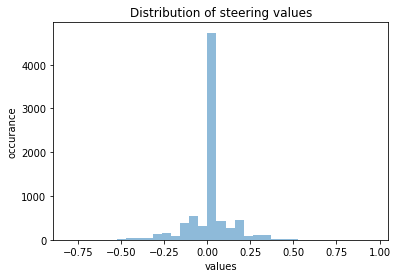

In [4]:
change_step=0.05 # test data changes
plot_histogram("steering values", steering_values, change_step)

# Speed value distribution

It appears, most of the driving is done at top speed of 30mph.

There is no sense to change speed in smaller increments than 1 mph.

min_value 0.5024896
max_value 30.70936
spread 30.2068704
recommended number of classes 31


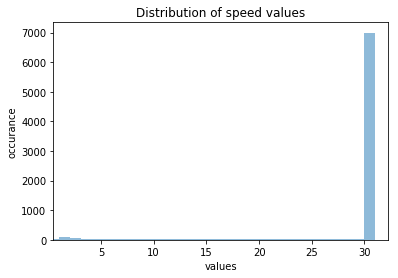

In [5]:
change_step=1 # test data changes
plot_histogram("speed values", speed_values, change_step)